# King County Affordable Housing for Millenials program

**Affordable housing in King County recommendations for Millennials**

**Authors:** Hanis Zulmuthi, Greg Burgess, Kyle Weesner

***March 2022***


<img src="https://www.condosky.com/wp-content/uploads/2019/06/Young-Families-Condos-Toronto-e1561577724820.jpg" alt="A picture of a multiracial family sitting on the floor together surrounded by moving boxes" title="" />

# Overview

King County in Washington State is growing in population made up of millenials and generation Z who either grew up or migrated to the area and found life in the region. We, the Data Analysts at the Greek Honey non-profit are woking on building a model that predicts house prices in King county with the goal to help folks from the demographic to find affordable houses, become homeowners and provide stable housing for themselves. 

# ADD A SUMMARY OF RESULTS HERE

## Business Problem

Housing market in King County region, especially in the major cities such as Seattle, are becoming more and more financially inaccessible for many demographics. The demographic of interest for our non-profit is millenials who are building their career, family and trying to break into the housing market to have a stable housing for themselves. With our house price predicition model, we will help them to find the market value of their ideal house that are in proximity to city centers.

## Data Understanding

### 1. King County Housing data ([kc_house_data.csv](https://github.com/hanis-z/Phase-2-project/blob/main/data/kc_house_data.csv))
**Source:** This data was provided to us by Flatiron School. This data file is available in the project repo in the folder "data". 

**Contents:**

### 2. Incorporated & Unincorporated cities in King county
**Source:** We downloaded this data from [King County GIS website]( https://gis-kingcounty.opendata.arcgis.com/datasets/kingcounty::cities-and-unincorporated-king-county-city-kc-area/explore?location=47.430582%2C-121.809200%2C10.02). The data is also easily accessible in our project repo in the folder "data".

**Contents:**

### 3. Neighborhood Map of Seattle
**Source:** We attained this data from [Seattle city GIS website](https://data-seattlecitygis.opendata.arcgis.com/datasets/neighborhood-map-atlas-districts/explore?location=47.628714%2C-122.338313%2C11.43]). This data is also easily accessible in our project repo in the folder "data".

**Contents:**


### Importing python libraries required for the analysis.

**Note:** To ensure that all packages are loaded successfully, please ensure that you are in the right python environment. For more reference, refer the (how-to-set-environment)[link to the file] to ensure you have the correct working environment to run this notebook.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import fiona
import geopandas as gpd
from shapely.geometry import Point
import pyproj
import folium

import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import RFE
from pandas.api.types import is_numeric_dtype
from sklearn.preprocessing import PolynomialFeatures

## Data Exploration & Preparation


### Load King County Housing data

In [32]:
housing_df = pd.read_csv('../data/housing_gdf_complete.csv')
housing_df= gpd.GeoDataFrame(df, crs="EPSG:4326")

In [9]:
housing_df.head()

,Unnamed: 0,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,...,lat,long,sqft_living15,sqft_lot15,coord,geometry,city,dist_seattle,neighborhood,in_seattle
0,0,8856004730,9/17/2014,199950.0,2,2.75,1590,20917,1.5,NO,...,47.2786,-122.250,1310,6000,"(-122.25, 47.2786)",POINT (392815.9311460542 31962.040946318088),Algona,38586.298196,NaN,False
1,1,3356406510,5/30/2014,196440.0,3,2.00,1560,7352,1.0,NO,...,47.2804,-122.251,1120,7950,"(-122.251, 47.2804)",POINT (392743.96777042677 32163.527499454583),Algona,38375.160433,NaN,False
2,2,3356404330,11/19/2014,206000.0,4,2.00,1720,7560,1.0,NO,...,47.2845,-122.250,1750,7988,"(-122.25, 47.2845)",POINT (392828.008518306 32617.90153434322),Algona,37943.562770,NaN,False
3,3,128500260,5/8/2014,262000.0,4,2.50,2020,6236,2.0,NO,...,47.2796,-122.247,1940,5076,"(-122.247, 47.2796)",POINT (393044.9257391654 32069.02917550225),Algona,38523.082722,NaN,False
4,4,8856004400,9/2/2014,235000.0,4,1.00,1610,24000,1.5,NO,...,47.2751,-122.252,1270,9600,"(-122.252, 47.2751)",POINT (392657.45531036914 31575.759156857133),Algona,38938.369932,NaN,False


In [10]:
housing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21596 entries, 0 to 21595
Data columns (total 28 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     21596 non-null  int64  
 1   id             21596 non-null  int64  
 2   date           21596 non-null  object 
 3   price          21596 non-null  float64
 4   bedrooms       21596 non-null  int64  
 5   bathrooms      21596 non-null  float64
 6   sqft_living    21596 non-null  int64  
 7   sqft_lot       21596 non-null  int64  
 8   floors         21596 non-null  float64
 9   waterfront     19221 non-null  object 
 10  view           21533 non-null  object 
 11  condition      21596 non-null  object 
 12  grade          21596 non-null  object 
 13  sqft_above     21596 non-null  int64  
 14  sqft_basement  21596 non-null  object 
 15  yr_built       21596 non-null  int64  
 16  yr_renovated   17754 non-null  float64
 17  zipcode        21596 non-null  int64  
 18  lat   

In [38]:
housing_df['dist_seattle'] = housing_df['dist_seattle']/1000

### Load shapefile data for cities in King county

In [77]:
#Read the file in using geopandas
kc_cities_gdf = gpd.read_file('../data/Cities_and_Unincorporated_King_County___city_kc_area/Cities_and_Unincorporated_King_County___city_kc_area.shp')


In [12]:
kc_cities_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   OBJECTID    100 non-null    int64   
 1   JURIS       100 non-null    object  
 2   CITYNAME    100 non-null    object  
 3   SHAPE_Leng  100 non-null    float64 
 4   SHAPE_Area  100 non-null    float64 
 5   geometry    100 non-null    geometry
dtypes: float64(2), geometry(1), int64(1), object(2)
memory usage: 4.8+ KB


In [13]:
kc_cities_gdf.head()

,OBJECTID,JURIS,CITYNAME,SHAPE_Leng,SHAPE_Area,geometry
0,1,AL,Algona,38144.667179,3.641105e+07,"POLYGON ((-122.24022 47.29353, -122.24307 47.2..."
1,2,AU,Auburn,209231.046799,7.856892e+08,"POLYGON ((-122.22820 47.35395, -122.22546 47.3..."
2,3,BA,Beaux Arts,6720.785802,2.274707e+06,"POLYGON ((-122.20276 47.58679, -122.20276 47.5..."
3,4,BD,Black Diamond,6629.569588,2.412697e+06,"POLYGON ((-121.96191 47.28836, -121.96191 47.2..."
4,5,BD,Black Diamond,85786.107116,1.983661e+08,"POLYGON ((-122.04854 47.34368, -122.04412 47.3..."


#### Note

Unincorporated cities in King County is labeled "King County" in the dataset. King County's official definition of Unincorporated cities is as follows:

"Rural unincorporated King County covers central and eastern King County and Vashon Island – areas outside the Urban Growth Boundary. These areas are desig- nated Rural, Agricultural or Forest Resource by the King County Comprehensive Plan."

We will rename unincorporated cities in king county to "Uincorporated City"

In [17]:
#View cities
kc_cities_gdf['CITYNAME'].unique()

array(['Algona', 'Auburn', 'Beaux Arts', 'Black Diamond', 'Bellevue',
       'Bothell', 'Burien', 'Carnation', 'Clyde Hill', 'Covington',
       'Des Moines', 'Duvall', 'Enumclaw', 'Federal Way', 'Hunts Point',
       'Issaquah', 'Unincorporated City', 'Kent', 'Kirkland', 'Kenmore',
       'Lake Forest Park', 'Medina', 'Mercer Island', 'Milton',
       'Maple Valley', 'North Bend', 'Newcastle', 'Normandy Park',
       'Pacific', 'Redmond', 'Renton', 'Seattle', 'Shoreline',
       'Skykomish', 'Sammamish', 'Snoqualmie', 'SeaTac', 'Tukwila',
       'Woodinville', 'Yarrow Point'], dtype=object)

In [15]:
#Rename "King County" to "Unincorporated City"
kc_cities_gdf['CITYNAME'] = kc_cities_gdf['CITYNAME'].str.replace('King County', 'Unincorporated City')

#Do a sniff test
kc_cities_gdf['CITYNAME'].unique()

array(['Algona', 'Auburn', 'Beaux Arts', 'Black Diamond', 'Bellevue',
       'Bothell', 'Burien', 'Carnation', 'Clyde Hill', 'Covington',
       'Des Moines', 'Duvall', 'Enumclaw', 'Federal Way', 'Hunts Point',
       'Issaquah', 'Unincorporated City', 'Kent', 'Kirkland', 'Kenmore',
       'Lake Forest Park', 'Medina', 'Mercer Island', 'Milton',
       'Maple Valley', 'North Bend', 'Newcastle', 'Normandy Park',
       'Pacific', 'Redmond', 'Renton', 'Seattle', 'Shoreline',
       'Skykomish', 'Sammamish', 'Snoqualmie', 'SeaTac', 'Tukwila',
       'Woodinville', 'Yarrow Point'], dtype=object)

We want our model to incorporate distance of properties from Seattle city center in predicting house price. So, here, we'll find the coordinates of the center of the cities.

In [30]:
#Get centroids of all cities in King County
kc_cities_gdf['centroid'] = kc_cities_gdf.centroid

#Sniff test
kc_cities_gdf.head()

,OBJECTID,JURIS,CITYNAME,SHAPE_Leng,SHAPE_Area,geometry,centroid
0,1,AL,Algona,38144.667179,3.641105e+07,"POLYGON ((393586.141 33607.604, 393361.732 331...",POINT (392791.391 32339.325)
1,2,AU,Auburn,209231.046799,7.856892e+08,"POLYGON ((394617.054 40308.323, 394823.902 403...",POINT (395834.289 35069.659)
2,3,BA,Beaux Arts,6720.785802,2.274707e+06,"POLYGON ((396999.450 66157.055, 396999.687 661...",POINT (397138.139 65993.350)
3,4,BD,Black Diamond,6629.569588,2.412697e+06,"POLYGON ((414627.020 32686.155, 414626.838 326...",POINT (414505.834 32499.483)
4,5,BD,Black Diamond,85786.107116,1.983661e+08,"POLYGON ((408171.066 38935.667, 408505.289 389...",POINT (410359.775 35532.648)


### [Seattle Neighborhood Data](https://data-seattlecitygis.opendata.arcgis.com/datasets/neighborhood-map-atlas-districts/explore?location=47.628714%2C-122.338313%2C11.43])

We would also like to explore how housing price within neighborhoods in Seattle vary, as an additional tool to help our clients decide where their ideal home location would be. 

So let's find the neighborhood the properties are in for the properties in Seattle.

#### Load Seattle Neighborhood data

In [69]:
#Load data using geopandas
neighborhood_gdf = gpd.read_file('../data/Neighborhood_Map_Atlas_Districts/Neighborhood_Map_Atlas_Districts.shp')



In [68]:
#Sniff test
neighborhood_gdf.head()

,OBJECTID,L_HOOD,S_HOOD_ALT,Shape__Are,Shape__Len,geometry
0,28,Ballard,"Loyal Heights, Adams, Whittier Heights, West W...",1.046035e+08,59248.568772,"POLYGON ((382213.992 78585.122, 382234.451 785..."
1,29,Beacon Hill,"North Beacon Hill, Mid-Beacon Hill, South Beac...",1.479894e+08,78783.502732,"POLYGON ((388742.711 67312.959, 388791.365 673..."
2,30,Capitol Hill,"Portage Bay, Montlake, Madison Park, Broadway,...",1.068562e+08,75147.170565,"MULTIPOLYGON (((390104.347 72404.965, 390101.6..."
3,31,Cascade,"Westlake, Eastlake, South Lake Union",2.717920e+07,48680.288698,"POLYGON ((388229.979 73605.275, 388238.056 736..."
4,32,Central Area,"Madrona, Harrison/Denny-Blaine, Minor, Leschi,...",9.527258e+07,52688.475894,"POLYGON ((391343.204 70826.981, 391340.461 708..."


In [38]:
#View the list of neighborhoodabs
neighborhood_gdf['L_HOOD'].unique()

array(['Ballard', 'Beacon Hill', 'Capitol Hill', 'Cascade',
       'Central Area', 'Delridge', 'Downtown', 'Interbay', 'Lake City',
       'Magnolia', 'Greater Duwamish', 'Northeast', 'Northgate',
       'Queen Anne', 'Rainier Valley', 'Seward Park', 'West Seattle',
       'Northwest', 'North Central', 'University District'], dtype=object)

## Data Mapping

In [18]:
housing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21596 entries, 0 to 21595
Data columns (total 28 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     21596 non-null  int64  
 1   id             21596 non-null  int64  
 2   date           21596 non-null  object 
 3   price          21596 non-null  float64
 4   bedrooms       21596 non-null  int64  
 5   bathrooms      21596 non-null  float64
 6   sqft_living    21596 non-null  int64  
 7   sqft_lot       21596 non-null  int64  
 8   floors         21596 non-null  float64
 9   waterfront     19221 non-null  object 
 10  view           21533 non-null  object 
 11  condition      21596 non-null  object 
 12  grade          21596 non-null  object 
 13  sqft_above     21596 non-null  int64  
 14  sqft_basement  21596 non-null  object 
 15  yr_built       21596 non-null  int64  
 16  yr_renovated   17754 non-null  float64
 17  zipcode        21596 non-null  int64  
 18  lat   

In [53]:
seattle_centroid = kc_cities_gdf[kc_cities_gdf['CITYNAME']=='Seattle']
seattle_centroid = seattle_centroid.iloc[0,-1]

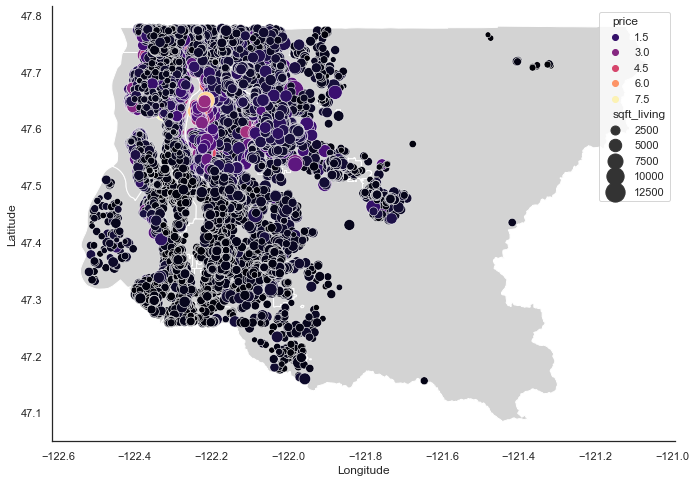

In [57]:
fig, ax = plt.subplots(figsize = (15,8))
# sns.set(rc = {'figure.figsize':(15,8)})
    
basemap = kc_cities_gdf.plot(ax=ax,color="lightgrey")
m = sns.scatterplot(x='long', y='lat', size='sqft_living', hue='price', palette="magma", sizes = (20,400), data=housing_df)
# c = seattle_centroid.plot(color = 'r')

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

sns.despine()

In [74]:
housing_df_seattle = housing_df[housing_df['city'] == 'Seattle']
mean_seattle_neighborhood = housing_df_seattle.groupby('neighborhood').mean()['price']
neighborhood_gdf_mean = neighborhood_gdf.merge(mean_seattle_neighborhood, left_on='L_HOOD', right_on = 'neighborhood' )

Text(0.5, 1.0, 'Mean house price by neighborhood in Seattle')

<Figure size 1080x576 with 0 Axes>

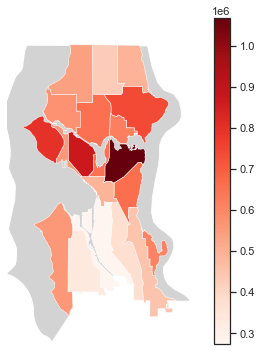

In [87]:
import geoplot as gplt

fig = plt.figure()



ax1 = gplt.choropleth(
    neighborhood_gdf_mean,
    hue='price',
    cmap='Reds', linewidth=0.5,
    edgecolor='white',
    legend=True
)

kc_cities_gdf[kc_cities_gdf['CITYNAME']=='Seattle'].plot(ax = ax1,color="lightgrey", zorder=0)


ax.set_title("Mean house price by neighborhood in Seattle")

## Data Cleaning

## Start EDA

<AxesSubplot:>

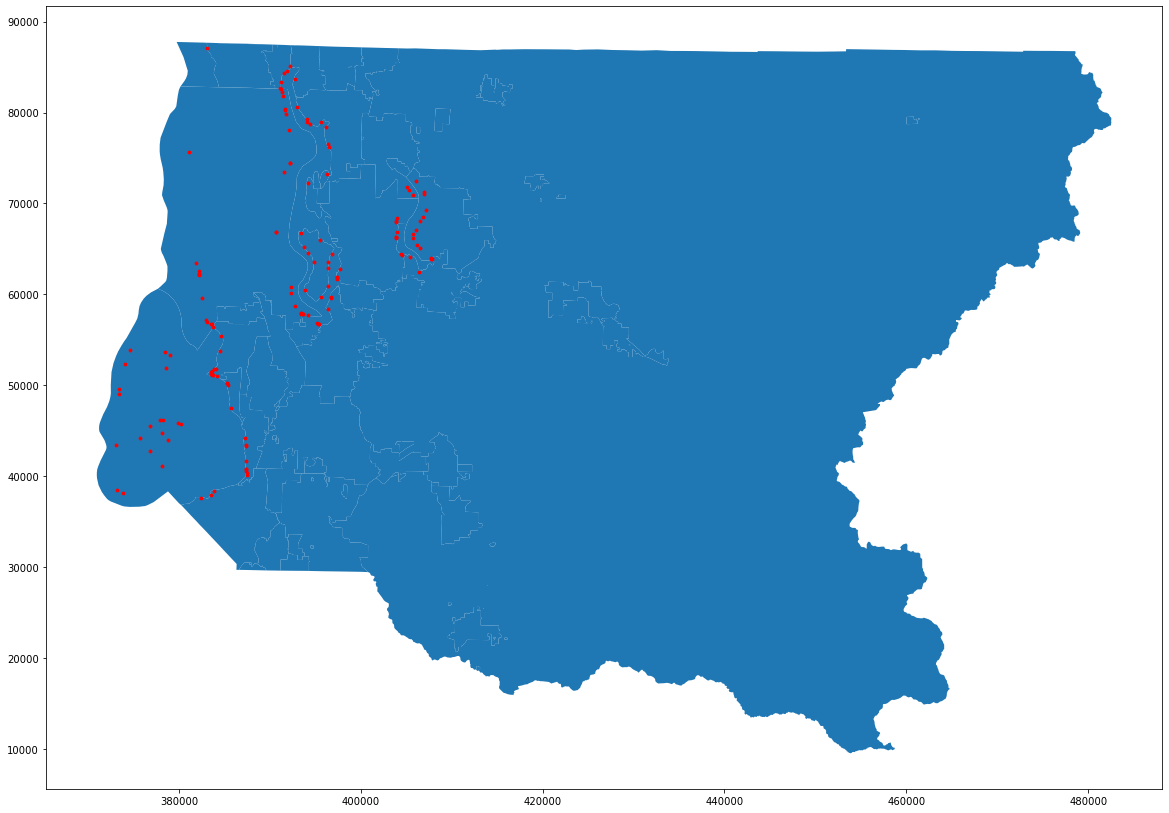

In [50]:
fig, ax = plt.subplots(figsize=(20,20))
wf.plot(ax = ax , color = 'r',markersize = 8,zorder=2)
# wf_nan.plot(ax=ax,color='k',markersize = 5, zorder=3)
kc_cities_gdf.plot(ax=ax,zorder=1)

## Explore plotting

In [52]:
kc_cities_gdf.head()

,OBJECTID,JURIS,CITYNAME,SHAPE_Leng,SHAPE_Area,geometry,centroid,distance_seattle
0,1,AL,Algona,38144.667179,3.641105e+07,"POLYGON ((-122.24022 47.29353, -122.24307 47.2...",POINT (392791.391 32339.325),38210.789361
1,2,AU,Auburn,209231.046799,7.856892e+08,"POLYGON ((-122.22820 47.35395, -122.22546 47.3...",POINT (395834.289 35069.659),36245.361339
2,3,BA,Beaux Arts,6720.785802,2.274707e+06,"POLYGON ((-122.20276 47.58679, -122.20276 47.5...",POINT (397138.139 65993.350),11935.852118
3,4,BD,Black Diamond,6629.569588,2.412697e+06,"POLYGON ((-121.96191 47.28836, -121.96191 47.2...",POINT (414505.834 32499.483),47120.537344
4,5,BD,Black Diamond,85786.107116,1.983661e+08,"POLYGON ((-122.04854 47.34368, -122.04412 47.3...",POINT (410359.775 35532.648),42216.811494


In [53]:
#m = folium.Map(location=[47.55, -121.9], zoom_start=9.5, tiles='CartoDB positron')
#for _, r in kc_cities_gdf.iterrows():
#    # Without simplifying the representation of each borough,
#    # the map might not be displayed
#    sim_geo = gpd.GeoSeries(r['geometry']).simplify(tolerance=0.001)
#    geo_j = sim_geo.to_json()
#    geo_j = folium.GeoJson(data=geo_j,
#                           style_function=lambda x: {'fillColor': 'orange'})
#    folium.Popup(r['CITYNAME']).add_to(geo_j)
#    geo_j.add_to(m)
#m

In [54]:
#for _, r in housing_gdf_complete.iterrows():
#    lat = r['geometry'].y
#    lon = r['geometry'].x
#    folium.Marker(location=[lat, lon]).add_to(m)
#m